# Librerías

In [53]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Limpieza de archivos

In [6]:
def limpiar_archivos_corruptos(path, format='.jpeg'):
  for filename in os.listdir(path):
    if filename.endswith(format):
      try:
        img = Image.open(os.path.join(path,filename)) # open the image file
        img.verify() # verify that it is, in fact an image
      except:
        os.remove(os.path.join(path,filename))
        print('Removiendo archivo corrupto:', filename) # print out the names of corrupt files

In [7]:
limpiar_archivos_corruptos("X-Ray-Pneumonia-Images/Images")

In [27]:
# Cuenta en número de imágenes
def contar_imagenes(path):
  return sum([len(files) for r, d, files in os.walk(path)])

print("Número de imágenes en el dataset:", contar_imagenes("X-Ray-Pneumonia-Images/Images"))

Número de imágenes en el dataset: 5856


# Lectura de datos

In [22]:
train_df = pd.read_csv('train.csv', index_col=0)
train_df.head()


,File_names,Target
Id,,
0,e184d851-45d7-50ff-85a9-9b75993484e7.jpeg,0
1,6e2c95c7-c0c2-565a-b3e2-d9de6eeb72ce.jpeg,1
2,2b7ca495-6101-5fe1-9c35-3a37e98a0cf2.jpeg,1
3,9d5fdc1a-22ac-5a4b-9942-694fa403765c.jpeg,1
4,786806b0-55cd-5aa3-a5d8-66701ffd77f7.jpeg,1


In [33]:
# Columnas de la data
train_df.columns

Index(['File_names', 'Target'], dtype='object')

In [55]:
train_df.shape

(4977, 2)

In [56]:
train_df['Target'].value_counts()

Target
1    3632
0    1345
Name: count, dtype: int64

# Carga de imagenes

In [44]:
# Crea una carpeta llamada Imagenes con subcarpetas para cada clase
os.makedirs('Imagenes', exist_ok=True)
os.makedirs('Imagenes/yes', exist_ok=True)
os.makedirs('Imagenes/no', exist_ok=True)


In [54]:
# Copia las imágenes a las carpetas correspondientes
for index, row in tqdm(train_df.iterrows()):
    img = imread(f'X-Ray-Pneumonia-Images/Images/{row["File_names"]}')
    if row['Target'] == 1:
        plt.imsave(f'Imagenes/yes/{row["File_names"]}', img)
    else:
        plt.imsave(f'Imagenes/no/{row["File_names"]}', img)

4977it [03:11, 26.02it/s]


In [64]:
path = 'Imagenes'

img_size = 224
batch_size = 32 # 64

In [65]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

""" train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
) """

' train_datagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=20,\n    zoom_range=0.15,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.15,\n    horizontal_flip=True,\n    fill_mode="nearest"\n) '

In [66]:
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size), batch_size=batch_size)

Found 4977 images belonging to 2 classes.


In [67]:
train_generator.class_indices

{'no': 0, 'yes': 1}

yes\41c2ae54-c3c4-5b3c-87bf-b75dd09a6a25.jpeg


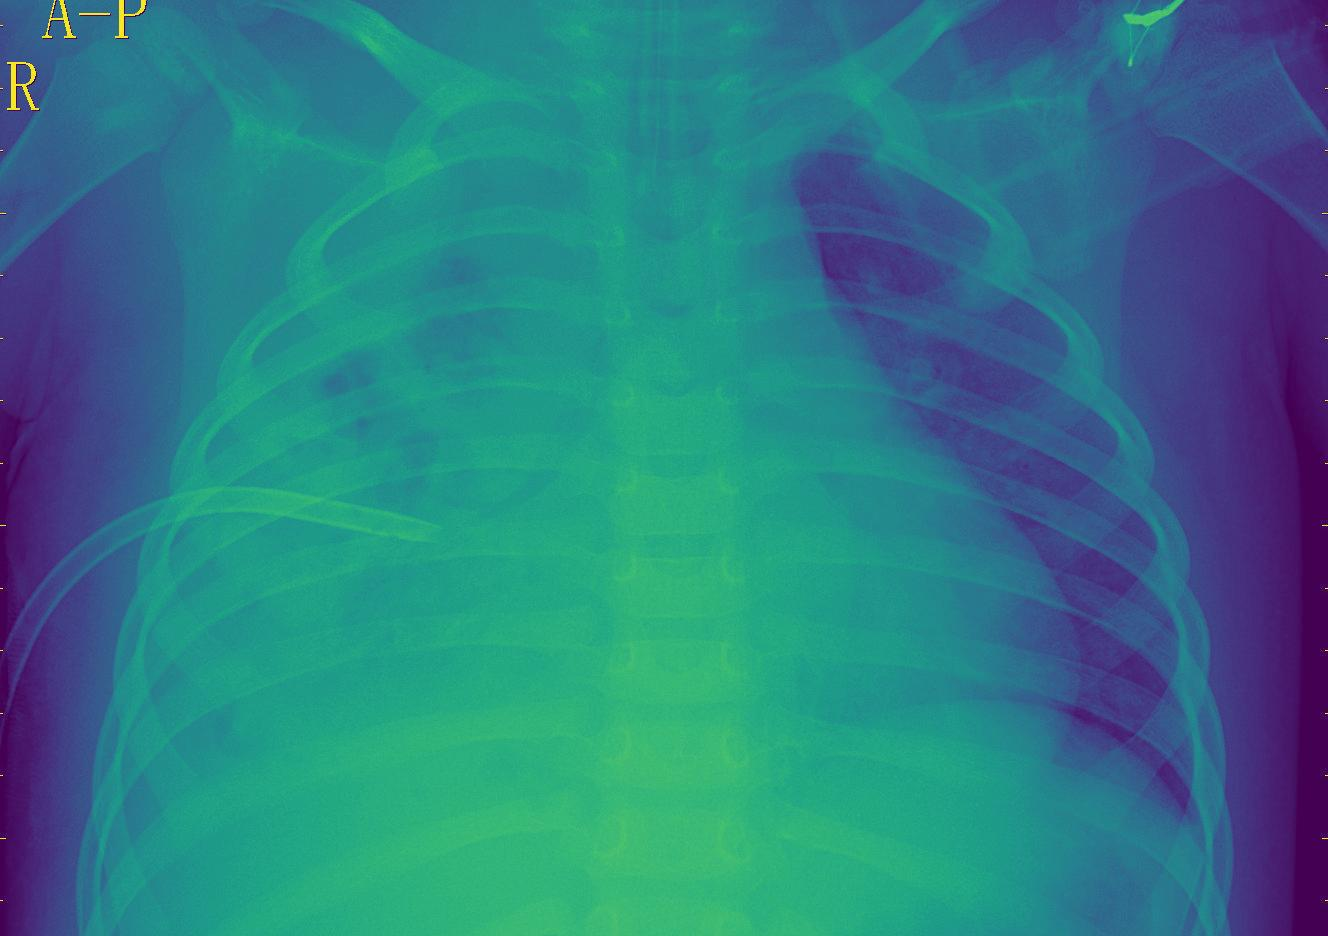

In [68]:
# Veamos alguna de las imágenes
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + '/' + random_img)

# Definición de modelos base

Propuesta de modelos preentrenados:
 - ResNet50
 - InceptionV3
 - DenseNet121

## Red preentrenada de ResNet50

In [79]:
# Carga el modelo ResNet50
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3), pooling='avg')
base_model_resnet.trainable = False
base_model_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [80]:
cls_model = Sequential()

cls_model.add(Dense(512, activation='relu', input_shape=base_model_resnet.output_shape[1:]))
cls_model.add(Dense(train_generator.num_classes, activation='softmax'))

cls_model.compile(
    optimizer=Adam(0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
cls_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,114 (4.01 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
final_model_resnet = Sequential()
final_model_resnet.add(base_model_resnet)
final_model_resnet.add(cls_model)

final_model_resnet.compile(
    optimizer=Adam(0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

final_model_resnet.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ ?                      │     1,050,114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,826 (93.99 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [82]:
train_generator2 = train_datagen.flow_from_directory(
    path, target_size=(img_size, img_size), batch_size=batch_size, shuffle=False
)

Found 4977 images belonging to 2 classes.


In [83]:
n_batches = math.ceil(train_generator2.samples / batch_size)
n_batches

156

In [124]:
train_generator2.reset()

# Variables donde vamos a guardar los features extraidos
outputs_x = []
outputs_y = []

for i in tqdm(range(n_batches)):
    x, y = next(train_generator2)
    outputs_x.append(base_model_resnet.predict_on_batch(x)) #base_model_resnet.predict(x)
    outputs_y.append(y)

outputs_x = np.concatenate(outputs_x)
outputs_y = np.concatenate(outputs_y)

100%|██████████| 156/156 [03:01<00:00,  1.16s/it]


In [125]:
outputs_x.shape, outputs_y.shape

((4977, 2048), (4977, 2))

In [126]:
# Guardamos los arrays
np.savez_compressed('Imagenes/no_yes_precomputed', x=outputs_x, y=outputs_y)

In [127]:
# Cargar arrays
data = np.load('Imagenes/no_yes_precomputed.npz')
outputs_x = data['x']
outputs_y = data['y']

outputs_x.shape, outputs_y.shape

((4977, 2048), (4977, 2))

In [128]:
outputs_x.shape

(4977, 2048)

In [129]:
log = cls_model.fit(
    outputs_x, outputs_y,
    epochs=10,
    batch_size=batch_size,
    #validation_split=0.2
)


Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9828 - loss: 0.0449
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9866 - loss: 0.0386
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9837 - loss: 0.0432
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0353
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0214
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9851 - loss: 0.0355
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9904 - loss: 0.0320
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9935 - loss: 0.0173
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9891 - loss: 0.0264
Epoch 10/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9945 - loss: 0.0180


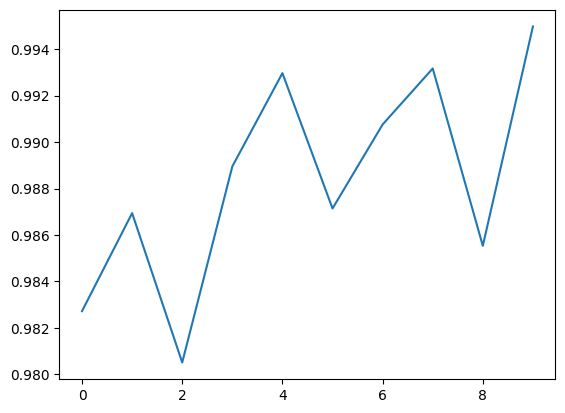

In [130]:
# Show the learning curves
plt.plot(log.history['accuracy'], label='accuracy')

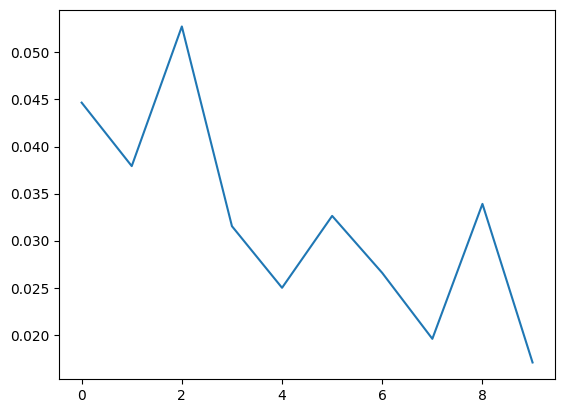

In [131]:
# Show loss
plt.plot(log.history['loss'], label='loss')

In [132]:
lbl_dict = {v: k for k, v in train_generator.class_indices.items()}

def get_class(img_path):

    # Cargar la imagen del path
    img = Image.open(img_path).convert('RGB')

    # Resize
    img_resized = img.resize((img_size, img_size))

    # Convertir a array
    x = np.asarray(img_resized, np.float32)[None]
    x = preprocess_input(x)

    # Obtener predicciones
    y = final_model_resnet.predict(x)

    # Decodear las predicciones
    pred = lbl_dict[np.argmax(y)]

    return pred

# Submission

In [133]:
# Crea un dataframe con las predicciones en base a test_x.csv

test_df = pd.read_csv('test_x.csv')
test_df.head()


,Id,File_names
0,0,1a8e3b37-63d9-5fbc-ac08-1575de9ca7b3.jpeg
1,1,c802f47b-126d-54da-8560-af9fc64594c0.jpeg
2,2,72cf7ea5-294a-5af3-8e75-4cddd685e9c7.jpeg
3,3,79080b42-3598-5418-930e-c6c29f59bf33.jpeg
4,4,57b2427f-dd56-5d1e-b5ad-84459c5a658a.jpeg


In [138]:
img_path = (f'X-Ray-Pneumonia-Images/Images/{submission_df['File_names'][0]}')
img = Image.open(img_path).convert('RGB')

# Show size of img
print(img.size)

(1310, 928)


In [134]:
# Genera las predicciones para el dataframe
test_df['Target'] = test_df['File_names'].apply(lambda x: get_class(f'X-Ray-Pneumonia-Images/Images/{x}'))

ValueError: Sequential model 'sequential_7' has already been configured to use input shape (None, 2048). You cannot build it with input_shape (1, 224, 224, 3)

In [110]:
# Crea un dataframe nuevo que contenga las predicciones de las imágenes de test
submission_df = test_df.copy()
submission_df['Predicted'] = submission_df['File_names'].apply(lambda x: get_class(f'X-Ray-Pneumonia-Images/Images/{x}'))



ValueError: Sequential model 'sequential_7' has already been configured to use input shape (None, 2048). You cannot build it with input_shape (1, 224, 224, 3)